In [118]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from arch import arch_model
import matplotlib.pyplot as plt



In [119]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [120]:

# Read the CSV file
stock1 = pd.read_csv("/Users/tobitlouis/Desktop/Data/individual_book_train/stock_1.csv")

# Feature engineering: add WAP and BidAskSpread columns
stock1["WAP"] = (
    stock1["bid_price1"] * stock1["ask_size1"]
  + stock1["ask_price1"] * stock1["bid_size1"]
) / (stock1["bid_size1"] + stock1["ask_size1"])

stock1["BidAskSpread"] = stock1["ask_price1"] / stock1["bid_price1"] - 1

# Now `stock1` has the two new columns
print(stock1.head())


   time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.000754    1.001542    1.000689    1.001607   
1        5                  1    1.000754    1.001673    1.000689    1.001739   
2        5                  2    1.000754    1.001411    1.000623    1.001476   
3        5                  3    1.000754    1.001542    1.000689    1.001607   
4        5                  4    1.000754    1.001476    1.000623    1.001542   

   bid_size1  ask_size1  bid_size2  ask_size2  stock_id       WAP  \
0          1         25         25        100         1  1.000785   
1         26         60         25        100         1  1.001032   
2          1         25         25        125         1  1.000780   
3        125         25        126         36         1  1.001411   
4        100        100         25         25         1  1.001115   

   BidAskSpread  
0      0.000787  
1      0.000918  
2      0.000656  
3      0.000787  
4      0

In [121]:

# (Optional) for reproducibility of any random ops—not strictly needed here
np.random.seed(3888)

def compute_log_returns(data: pd.DataFrame, tid) -> pd.DataFrame:
    sub = data[data["time_id"] == tid]
    sec = sub["seconds_in_bucket"].values
    price = sub["WAP"].values
    # compute log returns
    log_r = np.log(price[1:] / price[:-1])
    df = pd.DataFrame({"time": sec[1:], "log_return": log_r})
    
    # fill missing times 1…600 with zero-return entries
    all_times = np.arange(1, 601)
    missing = np.setdiff1d(all_times, df["time"].values)
    if missing.size:
        df = pd.concat([
            df,
            pd.DataFrame({"time": missing, "log_return": 0})
        ], ignore_index=True)
        df = df.sort_values("time").reset_index(drop=True)
    return df

# take first 500 unique time_ids
time_IDs = stock1["time_id"].unique()[:500]

# compute list of DataFrames of log-returns
log_r1 = [compute_log_returns(stock1, tid) for tid in time_IDs]

def comp_vol(x: np.ndarray) -> float:
    return np.sqrt((x**2).sum())

def compute_volatility(df: pd.DataFrame) -> pd.DataFrame:
    # assign 30-s buckets
    df = df.copy()
    df["time_bucket"] = np.ceil(df["time"] / 30).astype(int)
    # aggregate L2-norm of log_return per bucket
    vol_df = (
        df
        .groupby("time_bucket")["log_return"]
        .agg(comp_vol)
        .reset_index()
        .rename(columns={"log_return": "volatility"})
    )
    return vol_df

# apply to each series
vol = [compute_volatility(df) for df in log_r1]

In [122]:

# (Optional) Seed for reproducibility
np.random.seed(3888)

# Assume `vol` and `log_r1` already exist from the previous steps

# Split each volatility series into train (first 16 buckets) and validation (rest)
vol_train = [df.iloc[:16].reset_index(drop=True) for df in vol]
vol_val   = [df.iloc[16:].reset_index(drop=True) for df in vol]


# Add time_bucket and num_order to stock1
stock1["time_bucket"] = np.ceil(stock1["seconds_in_bucket"] / 30).astype(int)
stock1["num_order"]   = (
    stock1["bid_size1"]
  + stock1["ask_size1"]
  + stock1["bid_size2"]
  + stock1["ask_size2"]
)

# Store number of buckets in train/validation (they should be the same for all series)
len_train = len(vol_train[0]["volatility"])
len_val   = len(vol_val[0]["volatility"])

print(f"Training buckets:   {len_train}")
print(f"Validation buckets: {len_val}")

Training buckets:   16
Validation buckets: 4


In [123]:
list_reg = []
full_idx = np.arange(1, len_train)  # 1,2,…,len_train-1

for i, tid in enumerate(time_IDs):
    # 1) filter and select
    sb = stock1[
        (stock1["time_id"] == tid) &
        (stock1["time_bucket"] != 0)
    ][["time_bucket", "WAP", "num_order", "BidAskSpread"]]

    # 2) group & mean, then reindex to ensure every bucket is present
    mp = sb.groupby("time_bucket")["WAP"].mean().reindex(full_idx, fill_value=np.nan)
    mo = sb.groupby("time_bucket")["num_order"].mean().reindex(full_idx, fill_value=np.nan)
    mb = sb.groupby("time_bucket")["BidAskSpread"].mean().reindex(full_idx, fill_value=np.nan)

    # 3) now mp, mo, mb are all length len_train-1
    vols = vol_train[i]["volatility"].iloc[1:].values  # also length len_train-1

    # 4) build your regression DataFrame
    df_reg = pd.DataFrame({
        "volatility":   vols,
        "price":        mp.values,
        "order":        mo.values,
        "BidAskSpread": mb.values
    })

    list_reg.append(df_reg)

In [124]:


lm_models = []
for df_reg in list_reg:
    # Build X & y
    X = sm.add_constant(df_reg[["price", "order", "BidAskSpread"]])
    y = df_reg["volatility"]
    
    # Create the weights array (same length as full df_reg)
    exponents = np.arange(len_train - 2, -1, -1) / 2
    weights = 0.4 ** exponents
    
    # Drop any rows where X or y or weights are NaN/inf
    valid = (
        np.isfinite(y) &
        np.all(np.isfinite(X), axis=1) &
        np.isfinite(weights)
    )
    X_clean = X.loc[valid]
    y_clean = y.loc[valid]
    w_clean = weights[valid.values]  # weights is a 1d numpy array
    
    # Now fit WLS
    model = sm.WLS(y_clean, X_clean, weights=w_clean).fit()
    lm_models.append(model)

In [125]:

epsilon = 1e-6
n = len(vol)
pred_lm   = [None] * n
MSE_lm    = np.zeros(n)
QLIKE_lm  = np.zeros(n)

for i, tid in enumerate(time_IDs):
    # 1) filter & select
    sb = stock1[
        (stock1["time_id"] == tid) &
        (stock1["time_bucket"] != 0)
    ][["time_bucket", "WAP", "num_order", "BidAskSpread"]]
    
    # 2) group means as Series, then reindex to full bucket range [1..len_train+len_val-1]
    max_bucket = len_train + len_val - 1
    full_idx = np.arange(1, max_bucket + 1)
    
    mp = (
        sb.groupby("time_bucket")["WAP"]
          .mean()
          .reindex(full_idx, fill_value=np.nan)
    )
    mo = (
        sb.groupby("time_bucket")["num_order"]
          .mean()
          .reindex(full_idx, fill_value=np.nan)
    )
    mb = (
        sb.groupby("time_bucket")["BidAskSpread"]
          .mean()
          .reindex(full_idx, fill_value=np.nan)
    )
    
    # 3) slice out exactly the validation‐period buckets, which are from len_train … max_bucket
    start = len_train  # 1-based bucket index
    end   = max_bucket
    price_val = mp.values[start-1 : end]        # arrays of length len_val
    order_val = mo.values[start-1 : end]
    bas_val   = mb.values[start-1 : end]
    
    # 4) build df_val—now all arrays line up
    actual = vol_val[i]["volatility"].values
    df_val = pd.DataFrame({
        "volatility":   actual,
        "price":        price_val,
        "order":        order_val,
        "BidAskSpread": bas_val
    })
    
    # 5) clean any NaNs if you like (or let statsmodels ignore them)
    df_val_clean = df_val.dropna().reset_index(drop=True)
    
    # 6) predict & evaluate
    if not df_val_clean.empty:
        X_val = sm.add_constant(df_val_clean[["price", "order", "BidAskSpread"]])
        y_val = df_val_clean["volatility"].values
        
        preds = lm_models[i].predict(X_val)
        preds = np.where(preds <= 0, epsilon, preds)
        pred_lm[i] = preds
        
        MSE_lm[i]   = np.mean((y_val - preds) ** 2)
        QLIKE_lm[i] = np.mean(y_val / preds - np.log(y_val / preds) - 1)
    else:
        pred_lm[i] = np.array([])
        MSE_lm[i]  = np.nan
        QLIKE_lm[i]= np.nan

print("Average MSE:", np.nanmean(MSE_lm))
print("Average QLIKE:", np.nanmean(QLIKE_lm))

Average MSE: 4.865844006142123e-07
Average QLIKE: inf


In [126]:
#WLR Results


# pick out model at index 162
model_162 = lm_models[162]

# print the full regression table and diagnostics
print(model_162.summary())

                            WLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.171
Model:                            WLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                    0.7564
Date:                Sat, 17 May 2025   Prob (F-statistic):              0.541
Time:                        20:49:15   Log-Likelihood:                 94.575
No. Observations:                  15   AIC:                            -181.1
Df Residuals:                      11   BIC:                            -178.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1013      0.338      0.300   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [127]:
# Random Forest Regressor
np.random.seed(3888)
n_trees, max_features, epsilon = 500, 3, 1e-6

rf_models = []
pred_rf   = []
mse_list  = []
qlike_list= []

# Zip together the training and validation lists:
for train_df, val_df in zip(list_reg, list_reg_val):
    # 1) Fit RF on train_df
    X_train = train_df[["price","order","BidAskSpread"]].values
    y_train = train_df["volatility"].values
    rf = RandomForestRegressor(
        n_estimators=n_trees,
        max_features=max_features,
        random_state=3888
    )
    rf.fit(X_train, y_train)
    rf_models.append(rf)
    
    # 2) Predict on val_df
    X_val = val_df[["price","order","BidAskSpread"]].values
    preds = rf.predict(X_val)
    preds = np.where(preds <= 0, epsilon, preds)
    pred_rf.append(preds)
    
    # 3) Compute metrics
    y_val = val_df["volatility"].values
    mse_list.append(mean_squared_error(y_val, preds))
    qlike_list.append(np.mean(y_val/preds - np.log(y_val/preds) - 1))

# Convert lists to arrays if you like
MSE_rf   = np.array(mse_list)
QLIKE_rf = np.array(qlike_list)

print(f"Average RF MSE:   {np.nanmean(MSE_rf):.6e}")
print(f"Average RF QLIKE: {np.nanmean(QLIKE_rf):.6e}")

Average RF MSE:   1.925042e-07
Average RF QLIKE: 1.300285e-01


In [128]:
from sklearn.metrics import r2_score

# 1) Compute R² for each series
R2_rf = [
    r2_score(val_df["volatility"].values, preds)
    for val_df, preds in zip(vol_val, pred_rf)
]

# 2) Add R² into the performance DataFrame
perf_df = pd.DataFrame({
    "MSE":   MSE_rf,
    "QLIKE": QLIKE_rf,
    "R2":    R2_rf
})

perf_summary = perf_df.describe().rename(index={"50%":"median", "25%":"q1", "75%":"q3"})
print("=== RF Performance Summary ===")
print(perf_summary)


=== RF Performance Summary ===
                 MSE       QLIKE          R2
count   1.410000e+02  141.000000  141.000000
mean    1.925042e-07    0.130028   -2.378984
std     2.667596e-07    0.176748    4.905589
min     4.054925e-09    0.001338  -46.617581
q1      3.965681e-08    0.033808   -2.673272
median  8.373912e-08    0.075096   -0.918134
q3      2.230583e-07    0.161433   -0.204365
max     1.690582e-06    1.268907    0.537940


In [129]:
# HAV-OLS & HAV-WLS

# Function to compute quarticity: (n/3) * sum(x^4)
def comp_quar(x: pd.Series) -> float:
    return len(x) / 3 * np.sum(x**4)

quar = []
for df in log_r1:
    # 1) add time_bucket
    df = df.copy()
    df["time_bucket"] = np.ceil(df["time"] / 30).astype(int)
    
    # 2) group and compute quarticity
    q = (
        df
        .groupby("time_bucket")["log_return"]
        .agg(comp_quar)
        .reset_index()
        .rename(columns={"log_return": "quarticity"})
    )
    
    quar.append(q)

# `quar` is now a list of DataFrames, each with columns ['time_bucket', 'quarticity']

In [130]:

# reproducibility
np.random.seed(3888)

# 1) Build HAR feature frames for ALL series
list_HAV = []
for train_df in vol_train:
    vols = train_df["volatility"].to_numpy()
    n = len(vols)
    vol_1 = []
    mean_vol_5 = []
    # t runs from 5 .. n-1 (so we have at least one full past window)
    for t in range(5, n):
        vol_1.append(vols[t - 1])
        mean_vol_5.append(vols[max(0, t - 5) : t].mean())
    # assemble DataFrame
    df = pd.DataFrame({
        "vol": vols[5:],        # target
        "vol_1": vol_1,
        "mean_vol_5": mean_vol_5
    })
    list_HAV.append(df)

print("Built HAR frames:", len(list_HAV))

# 2) Fit HAR models: OLS and WLS
HAV_ols_models = []
HAV_wls_models = []

for i, df_hav in enumerate(list_HAV):
    # design matrix
    X = sm.add_constant(df_hav[["vol_1", "mean_vol_5"]])
    y = df_hav["vol"]
    
    # OLS
    ols_model = sm.OLS(y, X).fit()
    HAV_ols_models.append(ols_model)
    
    # prepare WLS weights from quarticity
    quart_arr = quar[i]["quarticity"].to_numpy()
    # our HAR frame has len(df_hav) == len(quart_arr) - 5
    # so slice quart_arr[5: 5 + len(df_hav)]
    w_raw = df_hav["vol_1"].to_numpy() / np.sqrt(quart_arr[5 : 5 + len(df_hav)])
    
    # drop any zero/invalid weights
    valid = (w_raw > 1e-8) & np.isfinite(w_raw)
    X_w = X.loc[valid]
    y_w = y.loc[valid]
    w = w_raw[valid]
    
    # fit WLS with fallback
    try:
        wls_model = sm.WLS(y_w, X_w, weights=w).fit()
    except np.linalg.LinAlgError:
        wls_model = ols_model  # fallback to OLS
    HAV_wls_models.append(wls_model)

print("Fitted HAR-OLS models:", len(HAV_ols_models))
print("Fitted HAR-WLS models:", len(HAV_wls_models))

Built HAR frames: 500
Fitted HAR-OLS models: 500
Fitted HAR-WLS models: 500


In [131]:

np.random.seed(3888)
epsilon = 1e-6

# We'll collect results in lists
pred_hav_ols, pred_hav_wls = [], []
mse_ols, mse_wls = [], []
qlike_ols, qlike_wls = [], []

for train_df, val_df, ols_model, wls_model in zip(
    vol_train, vol_val, HAV_ols_models, HAV_wls_models
):
    # Full series (train + validation)
    full_vol = np.concatenate([
        train_df["volatility"].values,
        val_df["volatility"].values
    ])
    n_train = len(train_df)
    n_val   = len(val_df)

    if n_val == 0:
        # nothing to do
        pred_hav_ols.append(np.array([]))
        pred_hav_wls.append(np.array([]))
        mse_ols.append(np.nan)
        mse_wls.append(np.nan)
        qlike_ols.append(np.nan)
        qlike_wls.append(np.nan)
        continue

    # Build vol_1 and mean_vol_5 for each validation point
    vol1  = np.empty(n_val)
    mean5 = np.empty(n_val)
    for k in range(n_val):
        idx = n_train + k         # index of this validation point in full_vol
        vol1[k] = full_vol[idx-1] # lag-1 always exists

        # for mean5, take up to 5 past values, but if fewer exist, use what you have
        start = max(0, idx - 5)
        mean5[k] = full_vol[start:idx].mean()

    # Build DataFrame for prediction
    df_val = pd.DataFrame({"vol_1": vol1, "mean_vol_5": mean5})
    # No need to drop rows now—there should be no NaNs

    # Design matrix
    X_val = sm.add_constant(df_val)

    # Predictions
    preds_ols = ols_model.predict(X_val)
    preds_wls = wls_model.predict(X_val)
    preds_ols = np.where(preds_ols <= 0, epsilon, preds_ols)
    preds_wls = np.where(preds_wls <= 0, epsilon, preds_wls)

    pred_hav_ols.append(preds_ols)
    pred_hav_wls.append(preds_wls)

    # True vols aligned 1–1 with preds
    actual = val_df["volatility"].values

    # Metrics
    mse_ols.append(np.mean((actual - preds_ols) ** 2))
    qlike_ols.append(np.mean(actual / preds_ols - np.log(actual / preds_ols) - 1))
    mse_wls.append(np.mean((actual - preds_wls) ** 2))
    qlike_wls.append(np.mean(actual / preds_wls - np.log(actual / preds_wls) - 1))

# Convert to numpy arrays if you like
MSE_hav_ols   = np.array(mse_ols)
QLIKE_hav_ols = np.array(qlike_ols)
MSE_hav_wls   = np.array(mse_wls)
QLIKE_hav_wls = np.array(qlike_wls)

print("Mean HAR-OLS MSE:",   np.nanmean(MSE_hav_ols))
print("Mean HAR-WLS MSE:",   np.nanmean(MSE_hav_wls))
print("Mean HAR-OLS QLIKE:", np.nanmean(QLIKE_hav_ols))
print("Mean HAR-WLS QLIKE:", np.nanmean(QLIKE_hav_wls))

Mean HAR-OLS MSE: 2.5432483609965045e-07
Mean HAR-WLS MSE: 3.212505442878528e-07
Mean HAR-OLS QLIKE: inf
Mean HAR-WLS QLIKE: inf


In [132]:
# Print the HAR‐OLS summary for time_id index 218
print(HAV_ols_models[218].summary())

                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.419
Date:                Sat, 17 May 2025   Prob (F-statistic):              0.297
Time:                        20:50:56   Log-Likelihood:                 71.351
No. Observations:                  11   AIC:                            -136.7
Df Residuals:                       8   BIC:                            -135.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.636      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [133]:
# Assuming you stored your WLS models in HAV_wls_models
print(HAV_wls_models[218].summary())

                            WLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.097
Model:                            WLS   Adj. R-squared:                 -0.129
Method:                 Least Squares   F-statistic:                    0.4283
Date:                Sat, 17 May 2025   Prob (F-statistic):              0.666
Time:                        20:50:56   Log-Likelihood:                 72.642
No. Observations:                  11   AIC:                            -139.3
Df Residuals:                       8   BIC:                            -138.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.043      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [134]:

# reproducibility
np.random.seed(3888)
epsilon = 1e-6

# 1) Fit ARMA(1,1) + GARCH(1,2) on the first 480s of each log-return series
arma_garch_models = []
for df in log_r1:
    data = df.loc[df["time"] <= 480, "log_return"]
    model = arch_model(
        data,
        mean="ARX", lags=1,
        vol="GARCH", p=1, q=2,
        dist="normal"
    )
    res = model.fit(disp="off")
    arma_garch_models.append(res)

# 2) Forecast 30‐step ahead RV via built-in simulation
n_steps = 30
n_sims  = 1000
RV_pred = np.empty(len(arma_garch_models))

for i, res in enumerate(arma_garch_models):
    # one call to run 1000 sims of 30-step ahead paths
    fc = res.forecast(
        horizon=n_steps,
        method="simulation",
        simulations=n_sims
    )
    # fc.simulations.values shape: (in_sample_index+1, horizon, n_sims)
    sims = fc.simulations.values
    # take the very last in-sample row’s out-of-sample block → shape (horizon, n_sims)
    last_horizon = sims[-1, :, :]
    # compute realized vol as mean over sims of sqrt(sum of squared returns)
    RV_pred[i] = np.mean(np.sqrt((last_horizon ** 2).sum(axis=0)))

# enforce positivity
RV_pred = np.where(RV_pred <= 0, epsilon, RV_pred)

# 3) Evaluate on first validation bucket
MSE_garch   = np.full(len(vol_val), np.nan)
QLIKE_garch = np.full(len(vol_val), np.nan)

for i, val_df in enumerate(vol_val):
    if len(val_df) > 0 and np.isfinite(RV_pred[i]):
        actual = val_df["volatility"].iloc[0]
        act = actual if actual > 0 else epsilon

        MSE_garch[i]   = (act - RV_pred[i]) ** 2
        QLIKE_garch[i] = act / RV_pred[i] - np.log(act / RV_pred[i]) - 1

print("Mean GARCH MSE:   ", np.nanmean(MSE_garch))
print("Mean GARCH QLIKE:", np.nanmean(QLIKE_garch))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.228e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model pa

Mean GARCH MSE:    240180.4208616653
Mean GARCH QLIKE: 1.1725433618784415


In [135]:
n = len(vol_val)
epsilon = 1e-6

# Ensure your error‐lists all have length n
# (If some predictions are missing, pad with NaN.)
def pad_or_nan(arr, n):
    out = np.full(n, np.nan)
    L = min(len(arr), n)
    out[:L] = arr[:L]
    return out

# Re‐pad everything to length n
MSE_lm_p   = pad_or_nan(MSE_lm,   n)
MSE_rf_p   = pad_or_nan(MSE_rf,   n)
MSE_hav_ols_p = pad_or_nan(MSE_hav_ols, n)
MSE_hav_wls_p = pad_or_nan(MSE_hav_wls, n)
MSE_garch_p   = pad_or_nan(MSE_garch,   n)

QLIKE_lm_p   = pad_or_nan(QLIKE_lm_recalc, n)
QLIKE_rf_p   = pad_or_nan(QLIKE_rf_recalc, n)
QLIKE_hav_ols_p = pad_or_nan(QLIKE_hav_ols, n)
QLIKE_hav_wls_p = pad_or_nan(QLIKE_hav_wls, n)
QLIKE_garch_p   = pad_or_nan(QLIKE_garch,   n)

# Build list of records
records = []
for i in range(n):
    for model, mse_arr, q_arr in [
        ("WLR",       MSE_lm_p,       QLIKE_lm_p),
        ("RF",        MSE_rf_p,       QLIKE_rf_p),
        ("HAV-OLS",   MSE_hav_ols_p,  QLIKE_hav_ols_p),
        ("HAV-WLS",   MSE_hav_wls_p,  QLIKE_hav_wls_p),
        ("ARMA-GARCH",MSE_garch_p,    QLIKE_garch_p),
    ]:
        records.append({
            "time_id_index": i,
            "Model": model,
            "MSE": mse_arr[i],
            "QLIKE": q_arr[i]
        })

metrics_data = pd.DataFrame.from_records(records)
# ensure categorical order
metrics_data["Model"] = pd.Categorical(
    metrics_data["Model"],
    categories=["WLR","RF","HAV-OLS","HAV-WLS","ARMA-GARCH"],
    ordered=True
)

print(metrics_data.head())

   time_id_index       Model           MSE     QLIKE
0              0         WLR  1.654531e-08  0.005050
1              0          RF  4.763831e-08  0.012857
2              0     HAV-OLS  1.814506e-08  0.005543
3              0     HAV-WLS  1.816789e-08  0.005797
4              0  ARMA-GARCH  4.616430e-05  0.961218


<Figure size 640x480 with 0 Axes>

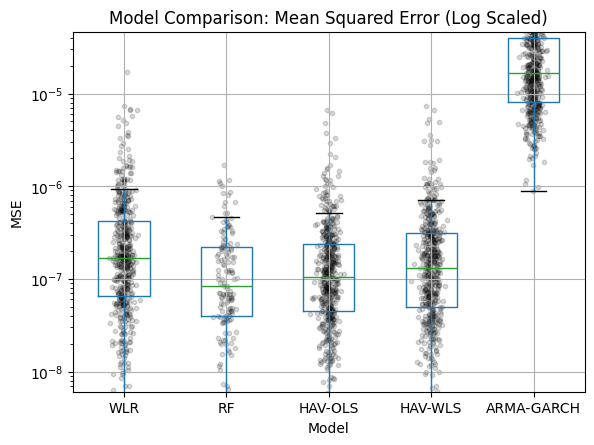

<Figure size 640x480 with 0 Axes>

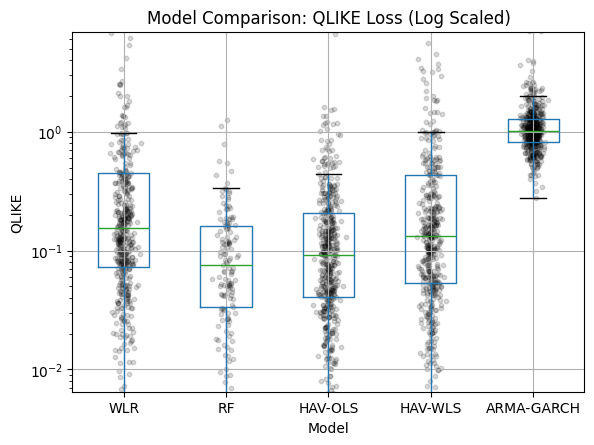

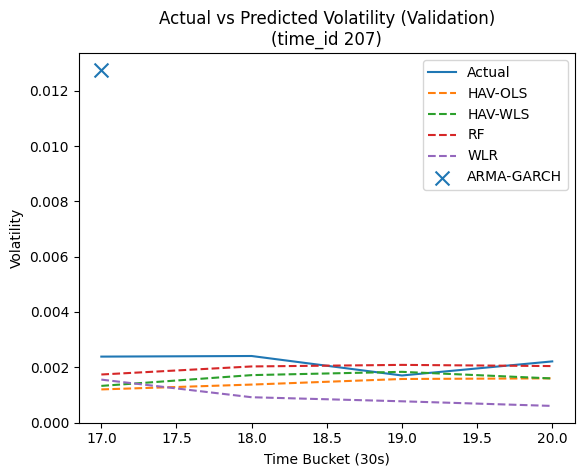

In [136]:

# 1) Boxplot of MSE (log scale + jitter)
df_mse = metrics_data[np.isfinite(metrics_data['MSE'])]
plt.figure()
df_mse.boxplot(column='MSE', by='Model', widths=0.5, showfliers=False)
for i, model in enumerate(df_mse['Model'].cat.categories):
    y = df_mse[df_mse['Model'] == model]['MSE'].values
    x = np.random.normal(i+1, 0.05, size=len(y))
    plt.scatter(x, y, alpha=0.15, s=10, color='black')
plt.yscale('log')
low, high = np.quantile(df_mse['MSE'], [0.01, 0.95])
plt.ylim(low, high)
plt.title("Model Comparison: Mean Squared Error (Log Scaled)")
plt.suptitle('')
plt.xlabel("Model")
plt.ylabel("MSE")
plt.show()

# 2) Boxplot of QLIKE (log scale + jitter)
df_qlike = metrics_data[np.isfinite(metrics_data['QLIKE'])]
plt.figure()
df_qlike.boxplot(column='QLIKE', by='Model', widths=0.5, showfliers=False)
for i, model in enumerate(df_qlike['Model'].cat.categories):
    y = df_qlike[df_qlike['Model'] == model]['QLIKE'].values
    x = np.random.normal(i+1, 0.05, size=len(y))
    plt.scatter(x, y, alpha=0.15, s=10, color='black')
plt.yscale('log')
low, high = np.quantile(df_qlike['QLIKE'], [0.01, 0.95])
plt.ylim(low, high)
plt.title("Model Comparison: QLIKE Loss (Log Scaled)")
plt.suptitle('')
plt.xlabel("Model")
plt.ylabel("QLIKE")
plt.show()

# 3) Sample Actual vs Predicted for one time_id
sample_index = 17
tb = vol_val[sample_index]['time_bucket']

# Ensure all predictions are positive (replace non-positive with epsilon)
epsilon = 1e-6

def safe_positive(arr):
    if arr is None or len(arr) == 0:
        return np.array([])
    arr = np.asarray(arr)
    return np.where(arr <= 0, epsilon, arr)

pred_lm_pos = [safe_positive(p) for p in pred_lm]
pred_rf_pos = [safe_positive(p) for p in pred_rf]

# Ensure RV_pred exists and is long enough for sample_index
if 'RV_pred' in locals() and len(RV_pred) > sample_index:
    RV_pred_pos = np.where(RV_pred <= 0, epsilon, RV_pred)
    garch_vol = RV_pred_pos[sample_index]
else:
    garch_vol = np.nan  # or skip plotting this point

# assemble wide DataFrame
wide = pd.DataFrame({
    'time_bucket': tb,
    'Actual':      vol_val[sample_index]['volatility'].values,
    'WLR':         pred_lm_pos[sample_index],
    'RF':          pred_rf_pos[sample_index],
    'HAV-OLS':     pred_hav_ols[sample_index],
    'HAV-WLS':     pred_hav_wls[sample_index],
})
# melt to long form
long = wide.melt(id_vars='time_bucket', var_name='Model', value_name='Volatility')

plt.figure()
for model, grp in long.groupby('Model'):
    style = '-' if model == 'Actual' else '--'
    plt.plot(grp['time_bucket'], grp['Volatility'], style, label=model)
# add ARMA-GARCH point if available
garch_tb = tb.iloc[0]
if not np.isnan(garch_vol):
    plt.scatter([garch_tb], [garch_vol], marker='x', s=100, label='ARMA-GARCH')

plt.title(f"Actual vs Predicted Volatility (Validation)\n(time_id {time_IDs[sample_index]})")
plt.xlabel("Time Bucket (30s)")
plt.ylabel("Volatility")
plt.legend(loc='best')
plt.show()